In [1]:
import uproot
import awkward as ak
import numpy as np
import vector
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import r2_score

In [2]:
cuts=[200,300,400]

In [3]:
def matching_procedure(cut):
    print("Processing files with",cut,"GeV cut")
    
    # Open LHE file
    with uproot.open("partons_"+str(cut)+".root:events") as f:
        #print(f.keys())
        px = f['px'].array()
        py = f['py'].array()
        pz = f['pz'].array()
        e = f['energy'].array()
        m = f['mass'].array()
        pid = f['pid'].array()
        m1 = f['mother1'].array()
        m2 = f['mother2'].array()

    # Extract top quark 3-Vector based on PID
    mask = pid==6
    top_px = px[mask]
    top_py = py[mask]
    top_pz = pz[mask]

    counts = ak.num(px)
    mask = counts==11
    print("\tHard Processes with 11 Partons:  ", len(counts[mask]), " / ", len(px))
    
    # Open Delphes file
    with uproot.open("dataset_"+str(cut)+".root:Delphes") as f:
        #print(f.keys())
        jet_pt = f['ParticleFlowJet15/ParticleFlowJet15.PT'].array()
        jet_eta = f['ParticleFlowJet15/ParticleFlowJet15.Eta'].array()
        jet_phi = f['ParticleFlowJet15/ParticleFlowJet15.Phi'].array()
        
    # Initialize lists for plotting
    pt_partons = []
    pt_fat_jets = []
    deltaR = []
    deltaEta = []
    deltaPhi = []

    missing_jet=0

    # Loop over all events
    num_events=len(jet_pt)
    for i in range(num_events):

        #if i%100==0:
        #    print("\tProcessing: ", i, " / ", len(jet_pt), end="\r")

        # Ensure only one top quark
        assert len(top_px[i])==1

        # Ensure at least one fat jet
        if len(jet_pt[i])<1:
            missing_jet+=1
            continue

        # Save parton 3-Vector
        parton = vector.MomentumObject3D(px=top_px[i][0], py=top_py[i][0], pz=top_pz[i][0])

        # Find closest fat jet in deltaR
        delR = []
        for j in range(len(jet_pt[i])):
            delR.append(parton.deltaR(vector.MomentumObject3D(pt=jet_pt[i][j], eta=jet_eta[i][j], phi=jet_phi[i][j])))
        argmin = np.argmin(delR)

        candidate = vector.MomentumObject3D(pt=jet_pt[i][argmin], eta=jet_eta[i][argmin], phi=jet_phi[i][argmin])
        if abs(parton.deltaphi(candidate))>2:
            continue
        #if abs(parton.deltaeta(candidate))>2:
        #    continue

        # Closest jet in deltaR to parton is matched jet
        matched_jet = candidate

        # Fill lists for plotting
        pt_partons.append(parton.pt)
        pt_fat_jets.append(matched_jet.pt)
        deltaR.append(parton.deltaR(matched_jet))
        deltaEta.append(parton.deltaeta(matched_jet))
        deltaPhi.append(parton.deltaphi(matched_jet))

    print("\tEvents without reco jet: ", missing_jet, "/", num_events)
    print()
    return pt_partons,pt_fat_jets,deltaR,deltaEta,deltaPhi

In [4]:
results=[]
for cut in cuts:
    results.append(matching_procedure(cut))

Processing files with 200 GeV cut
	Hard Processes with 11 Partons:   357  /  20000
	Events without reco jet:  6225 / 20000

Processing files with 300 GeV cut
	Hard Processes with 11 Partons:   332  /  20000
	Events without reco jet:  5411 / 20000

Processing files with 400 GeV cut
	Hard Processes with 11 Partons:   346  /  20000
	Events without reco jet:  5519 / 20000



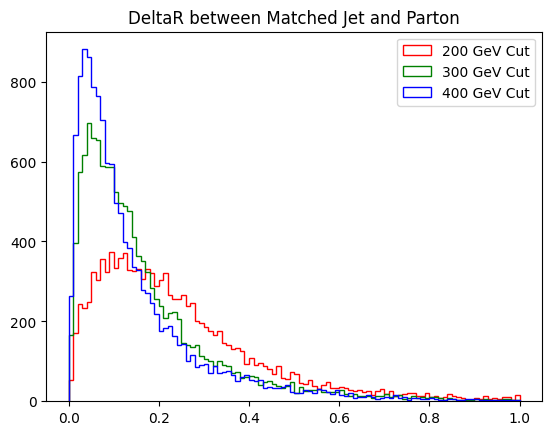

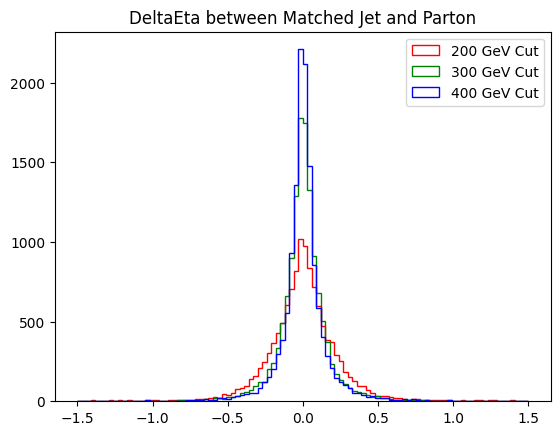

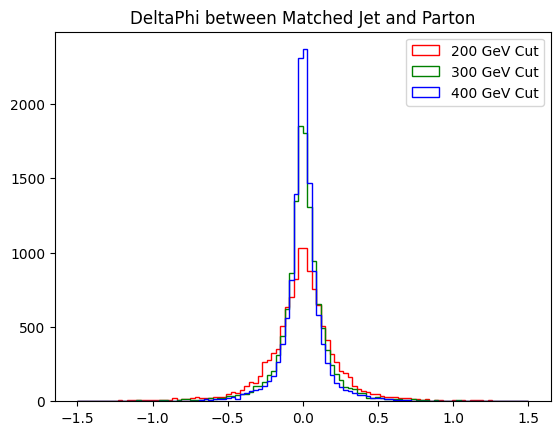

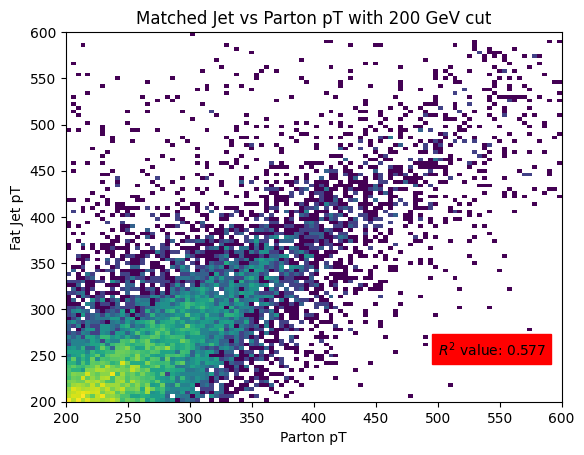

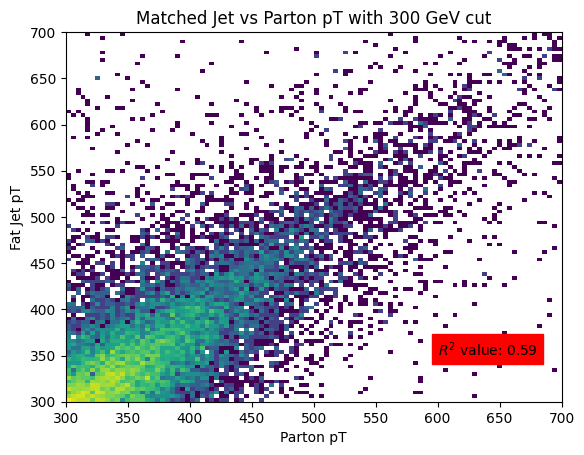

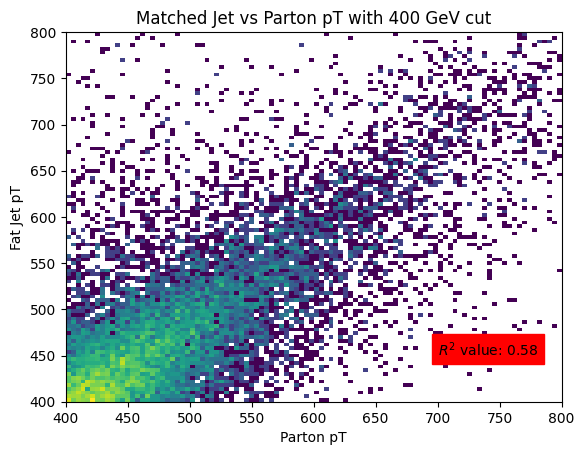

In [6]:
#fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()

colors=['r','g','b']

for result,cut,color in zip(results,cuts,colors):
    pt_partons,pt_fat_jets,deltaR,deltaEta,deltaPhi=result
    
    fig1, ax1 = plt.subplots()
    ax1.set_title("Matched Jet vs Parton pT with "+str(cut)+" GeV cut")
    ax1.hist2d(pt_partons,pt_fat_jets, bins=100,norm=mcolors.LogNorm(),range=((cut,cut+400),(cut,cut+400)))
    ax1.set_xlabel("Parton pT")
    ax1.set_ylabel("Fat Jet pT")
    ax1.text(cut+300,cut+50,"$R^2$ value: "+str(round(r2_score(pt_partons,pt_fat_jets),3)),backgroundcolor='r',color='k')

    ax2.set_title("DeltaR between Matched Jet and Parton")
    ax2.hist(deltaR,histtype='step',bins=100,color=color,range=(0,1),label=str(cut)+" GeV Cut")
    #ax2.set_yscale("log")
    ax2.legend()

    ax3.set_title("DeltaEta between Matched Jet and Parton")
    ax3.hist(deltaEta,histtype='step',bins=100,color=color,range=(-1.5,1.5),label=str(cut)+" GeV Cut")
    #ax3.set_yscale("log")
    ax3.legend()


    ax4.set_title("DeltaPhi between Matched Jet and Parton")
    ax4.hist(deltaPhi,histtype='step',bins=100,color=color,range=(-1.5,1.5),label=str(cut)+" GeV Cut")
    #ax4.set_yscale("log")
    ax4.legend()
    
plt.show()